## Import

In [127]:
# Import internal modules
import os.path
import joblib
import time
from typing import List, Set, Dict, Tuple, Optional

# Import 3rd party modules
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

## Load dataset

In [9]:
df = pd.read_csv(os.path.join("assets","data","thread_csv_all.csv"))
df.head()

,noise_db,machine_type,model_id,sound,sound_path,target,spect_mean,spect_min,spect_max,spect_std,...,zero_crossing_rate_max,zero_crossing_rate_std,d_harmonic_mean,d_harmonic_min,d_harmonic_max,d_harmonic_std,d_percussive_mean,d_percussive_min,d_percussive_max,d_percussive_std
0,-6,slider,0,00000000.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.107133,1.922508e-11,8.000317,0.286640,...,0.125488,0.015289,0.059173,1.413419e-12,7.861723,0.217199,0.047960,1.447360e-11,2.427006,0.102428
1,-6,slider,0,00000001.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.091550,1.239772e-10,11.825641,0.306949,...,0.122559,0.022209,0.051675,1.856747e-13,11.707416,0.261016,0.039876,7.817087e-11,2.639281,0.086876
2,-6,slider,0,00000002.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.114412,2.546376e-10,8.061798,0.300529,...,0.107422,0.013853,0.061442,5.859085e-13,7.840732,0.220184,0.052971,7.954731e-11,2.856351,0.114448
3,-6,slider,0,00000003.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.108589,6.224236e-11,7.651740,0.277428,...,0.125488,0.012602,0.064017,1.636899e-13,7.523073,0.240022,0.044573,2.057399e-11,1.847202,0.077006
4,-6,slider,0,00000004.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.107343,9.855214e-12,7.804570,0.287012,...,0.119141,0.010417,0.064301,1.400486e-13,7.756195,0.248836,0.043042,4.824911e-12,2.022621,0.079337


In [165]:
df.shape

(54057, 70)

## Feature engineering 

In [49]:
# Replace abnormal by 1, normal by 0
df.target = df.target.apply(lambda x: 1 if x == "abnormal" else 0)

## Feature selection

In [71]:
# ## select numeric columns
# selected_cols = df.select_dtypes(include="number").columns.tolist()

# ## drop noise_db and model_id columns
# selected_cols.remove("noise_db")
# selected_cols.remove("model_id")

# print(selected_cols)

selected_cols = [
"rms_std",
"rms_max",
"d_percussive_max",
"d_percussive_std",
"chroma_min",
"mel_spect_std",
"cent_std",
"tonnetz_mean",
"zero_crossing_rate_std",
"spect_mean",
"tonnetz_std",
"roll_off_max",
"tonnetz_max",
"chroma_cq_mean",
"chroma_cens_max",
"contrast_min",
"chroma_mean",
"spec_bw_mean",
"tonnetz_min",
"zero_crossing_rate_mean",
]

In [90]:
# Select features X and target variable y
X = df[selected_cols]
y = df.target

## Split dataset

In [91]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y
                                                   )

print(f"X_train: {X_train.shape}   - y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}    - y_train: {y_test.shape}")

X_train: (43245, 20)   - y_train: (43245,)
X_test:  (10812, 20)    - y_train: (10812,)


In [142]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='auto')

# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, y_train)

## Models

In [149]:
# 1. Create pipelines
pipe_random_forest = make_pipeline(RandomForestClassifier(random_state=5))
pipe_decision_tree = make_pipeline(DecisionTreeClassifier(random_state=5))
pipe_svm = make_pipeline(SVC(random_state=5))
pipe_logistic_regression = make_pipeline(LogisticRegression(random_state=5))
pipe_balanced_random_forest = make_pipeline(BalancedRandomForestClassifier(random_state=5))
pipe_xgboost_classifier = make_pipeline(XGBClassifier())


# 2. GridSearchCV for each pipeline: to train models with different parameters
# and get the best models (for each pipeline) with the best parameters
scoring = {'recall_score': "recall", 'roc_auc_score': 'roc_auc'}

cv_stratified = StratifiedKFold(n_splits=10)

## 2.1 Define grid search parameters
grid_params_random_forest = {
    'randomforestclassifier__n_estimators': [90, 100, 110],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

grid_params_decision_tree = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_params_svm = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [9, 10]
}

grid_params_logistic_regression = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [1.0, 0.5],
    'logisticregression__solver': ['liblinear']
}

grid_params_balanced_random_forest = {
    'balancedrandomforestclassifier__n_estimators': [90, 100, 110],
    'balancedrandomforestclassifier__criterion': ['gini', 'entropy']
}

grid_params_xgboost_classifier = {
    'xgbclassifier__max_depth': [10, 11]
}

## 2.2 Instantiate grid searches
### set n_jobs to -1 to use all processors
n_jobs: int = 3

grid_random_forest = GridSearchCV(
    estimator=pipe_random_forest,
    param_grid=grid_params_random_forest,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_decision_tree = GridSearchCV(
    estimator=pipe_decision_tree,
    param_grid=grid_params_decision_tree,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_random_logistic_regression = GridSearchCV(
    estimator=pipe_logistic_regression,
    param_grid=grid_params_logistic_regression,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
)

grid_balanced_random_forest = GridSearchCV(
    estimator=pipe_balanced_random_forest,
    param_grid=grid_params_balanced_random_forest,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_xgboost_classifier = GridSearchCV(
    estimator=pipe_xgboost_classifier,
    param_grid=grid_params_xgboost_classifier,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

In [150]:
## 2.3 Create dict of grids
grids: Dict[str, GridSearchCV] = {
    "random_forest": grid_random_forest,
    "decision_tree": grid_decision_tree,
    "logistic_regression": grid_random_logistic_regression,
    "balanced_random_forest": grid_balanced_random_forest,
    "xgboost_classifier": grid_xgboost_classifier
}

# 2.4 Keep track of the best accuracy score
best_recall = 0.0
best_model = None
best_model_name = ""    
    
## 2.4 Fit the grids to the training set
for grid_name, grid in grids.items():
    start_time = time.time()
    print(f"Fitting training with {grid_name}")
    grid.fit(X_train, y_train)
    print(f'best params: {grid.best_params_}')
    print(f'best training recall: {grid.best_score_}')
    
    # print scores of all the scorers
    print(f'best scorer:{grid.cv_results_}')

    # predict on test set with best parameters
    y_pred = grid.predict(X_test)
    recall_score_value = recall_score(y_test, y_pred)
    print(f'recall_score on test set with best parameters: {recall_score_value}')

    # Update the best model
    if recall_score_value > best_recall:
        best_recall = recall_score_value
        best_model = grid
        best_model_name = grid_name
    
    # Print time to select best model within a grid
    end_time = time.time()
    diff_time_m = (end_time - start_time)/60
    print(f"Time to select best {grid_name}: {diff_time_m:.2f} minutes")
print(f"Conclusion: model with best recall on test set: {best_model_name}")

Fitting training with random_forest
best params: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 100}
best training recall: 0.8444444444444444
best scorer:{'mean_fit_time': array([4.33616879, 4.56583312, 4.99989083, 5.80107474, 6.41626873,
       6.89452214]), 'std_fit_time': array([0.13791706, 0.12815057, 0.14005717, 0.26620853, 0.33125702,
       0.33533575]), 'mean_score_time': array([0.02811353, 0.02835376, 0.03155959, 0.026316  , 0.02888024,
       0.03157132]), 'std_score_time': array([0.00305683, 0.0014666 , 0.00207982, 0.0014788 , 0.00109572,
       0.00202155]), 'param_randomforestclassifier__criterion': masked_array(data=['gini', 'gini', 'gini', 'entropy', 'entropy',
                   'entropy'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_randomforestclassifier__n_estimators': masked_array(data=[90, 100, 110, 90, 100, 110],
             mask=[False, False, Fal

/Users/derrickvanfrausum/anaconda3/envs/mimii/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/derrickvanfrausum/anaconda3/envs/mimii/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/derrickvanfrausum/anaconda3/envs/mimii/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


best params: {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
best training recall: 0.6071969696969697
best scorer:{'mean_fit_time': array([1.56081545, 0.06847939, 1.56517644, 0.06291952]), 'std_fit_time': array([0.30123183, 0.00784404, 0.22015628, 0.00358682]), 'mean_score_time': array([0.00281298, 0.00187266, 0.00260875, 0.00222564]), 'std_score_time': array([6.57702360e-04, 7.30595797e-05, 5.41534625e-04, 4.68685387e-04]), 'param_logisticregression__C': masked_array(data=[1.0, 1.0, 0.5, 0.5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_logisticregression__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_logisticregression__solver': masked_array(data=['liblinear', 'liblinear', 'liblinear', 'liblinear'],
             mask=[False, False, False, False],
    

/Users/derrickvanfrausum/anaconda3/envs/mimii/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best params: {'xgbclassifier__max_depth': 10}
best training recall: 0.8651515151515152
best scorer:{'mean_fit_time': array([9.53687122, 9.06958799]), 'std_fit_time': array([0.75245795, 1.43897829]), 'mean_score_time': array([0.01567943, 0.00783212]), 'std_score_time': array([0.01007786, 0.00212121]), 'param_xgbclassifier__max_depth': masked_array(data=[10, 11],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'xgbclassifier__max_depth': 10}, {'xgbclassifier__max_depth': 11}], 'split0_test_recall_score': array([0.88510101, 0.87752525]), 'split1_test_recall_score': array([0.86363636, 0.86742424]), 'split2_test_recall_score': array([0.87121212, 0.86489899]), 'split3_test_recall_score': array([0.

In [148]:
best_model.cv_results_

{'mean_fit_time': array([7.86787999]),
 'std_fit_time': array([1.72171306]),
 'mean_score_time': array([0.01232252]),
 'std_score_time': array([0.00502672]),
 'param_xgbclassifier__max_depth': masked_array(data=[9],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'xgbclassifier__max_depth': 9}],
 'split0_test_recall_score': array([0.86994949]),
 'split1_test_recall_score': array([0.87121212]),
 'split2_test_recall_score': array([0.86616162]),
 'split3_test_recall_score': array([0.83838384]),
 'split4_test_recall_score': array([0.85353535]),
 'split5_test_recall_score': array([0.88005051]),
 'split6_test_recall_score': array([0.85353535]),
 'split7_test_recall_score': array([0.86111111]),
 'split8_test_recall_score': array([0.85858586]),
 'split9_test_recall_score': array([0.85227273]),
 'mean_test_recall_score': array([0.8604798]),
 'std_test_recall_score': array([0.0112968]),
 'rank_test_recall_score': array([1], dtype=int32)}

In [151]:
## 2.5 Save the best grid search pipeline to joblib file
filepath = os.path.join("assets","data","best_model.joblib")
joblib.dump(best_model, filepath, compress=1)
print(f"Best model ({best_model_name}) is saved")

## 2.6 Load the model
loaded_model = joblib.load(filepath) 

print(loaded_model)
print("Best parameters: loaded_model.best_params_")
print(classification_report(y_test, loaded_model.predict(X_test)))

Best model (xgboost_classifier) is saved
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_de.

In [152]:
confusion_matrix(y_test, loaded_model.predict(X_test))

array([[7820, 1012],
       [ 263, 1717]])

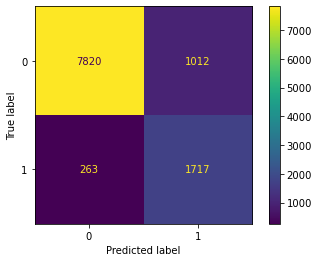

In [153]:
plot_confusion_matrix(loaded_model, X_test, y_test);

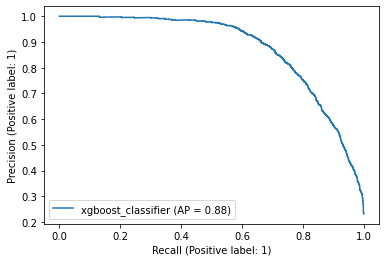

In [156]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(loaded_model, X_test, y_test, name = best_model_name);

In [114]:
X_test.iloc[[1]]

,rms_std,rms_max,d_percussive_max,d_percussive_std,chroma_min,mel_spect_std,cent_std,tonnetz_mean,zero_crossing_rate_std,spect_mean,tonnetz_std,roll_off_max,tonnetz_max,chroma_cq_mean,chroma_cens_max,contrast_min,chroma_mean,spec_bw_mean,tonnetz_min,zero_crossing_rate_mean
28489,0.000907,0.008228,3.090454,0.075248,0.184796,0.092794,127.90084,-0.02459,0.006872,0.074043,0.080171,5943.164062,0.143502,0.515873,0.57216,5.040021,0.552856,1406.862854,-0.296043,0.050134


In [112]:
loaded_model.predict(X_test.iloc[[1]])

array([0])

In [113]:
y_test.iloc[[1]]

28489    0
Name: target, dtype: int64

## ML for each machine type

In [166]:
for machine_type in df.machine_type.unique():

    # Select features X and target variable y for each machine type sounds
    X = df[selected_cols].loc[df.machine_type == machine_type]
    y = df.target.loc[df.machine_type == machine_type]
    print(f"************** {machine_type} **************")
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y
                                                       )

    print(f"X_train: {X_train.shape}   - y_train: {y_train.shape}")
    print(f"X_test:  {X_test.shape}    - y_train: {y_test.shape}")

#     from imblearn.under_sampling import RandomUnderSampler
#     undersample = RandomUnderSampler(sampling_strategy='auto')

    # fit and apply the transform
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    
    print(machine_type)
    print(best_model_name_by_machine_type[machine_type])
    print(f"Best parameters: {best_model_by_machine_type[machine_type].best_params_}")
    print(classification_report(y_test, best_model_by_machine_type[machine_type].predict(X_test)))

************** slider **************
X_train: (9825, 20)   - y_train: (9825,)
X_test:  (2457, 20)    - y_train: (2457,)
slider
xgboost_classifier
Best parameters: {'xgbclassifier__max_depth': 11}
              precision    recall  f1-score   support

           0       0.73      0.27      0.39      1923
           1       0.20      0.65      0.30       534

    accuracy                           0.35      2457
   macro avg       0.46      0.46      0.35      2457
weighted avg       0.61      0.35      0.37      2457

************** valve **************
X_train: (10008, 20)   - y_train: (10008,)
X_test:  (2502, 20)    - y_train: (2502,)
valve
xgboost_classifier
Best parameters: {'xgbclassifier__max_depth': 11}
              precision    recall  f1-score   support

           0       0.88      0.18      0.30      2215
           1       0.11      0.81      0.20       287

    accuracy                           0.25      2502
   macro avg       0.50      0.50      0.25      2502
weighted 